In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

In [89]:
conn=sqlite3.connect("../../db/proyectomacro.db")
df_tasa=pd.read_sql("SELECT * FROM Tasa_Crecimiento_PIB",conn)
df_precios_minerales=pd.read_sql_query('SELECT año,zinc,estaño,plata,oro FROM precio_oficial_minerales where año>1955 and año<2024',conn)
df_precios_petroleo=pd.read_sql_query('SELECT año,precio as precio_petroleo FROM precio_petroleo_wti',conn)
df_reservas=pd.read_sql_query('SELECT * FROM Reservas_oro_divisas ',conn)
df_inflacion=pd.read_sql_query('SELECT * FROM inflacion_general_acumulada',conn)
conn.close()
df_reservas.head()

,año,reservas_totales
0,1950,22190713.62
1,1951,30052042.41
2,1952,28624676.22
3,1953,24158127.92
4,1954,18928236.21


In [90]:
#juntar todos los df en uno solo y con años desde 2006 en adelante

# Unir los DataFrames por año
df = df_tasa \
    .merge(df_precios_minerales, on="año", how="inner") \
    .merge(df_precios_petroleo, on="año", how="inner") \
    .merge(df_reservas, on="año", how="inner") \
    .merge(df_inflacion, on="año", how="inner")
# Filtrar registros desde 2006 en adelante
df = df[df["año"] >= 2006]

# Mostrar los primeros registros

In [91]:
from statsmodels.tsa.stattools import grangercausalitytests
df['precio_petroleo_diff'] = df['precio_petroleo'].pct_change() * 100
df.dropna(inplace=True)
grangercausalitytests(df[['crecimiento', 'precio_petroleo_diff']], maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9959  , df_denom=13, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9954  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9954  , df=1
parameter F test:         F=0.0000  , p=0.9959  , df_denom=13, df_num=1


{1: ({'ssr_ftest': (2.7150275331973342e-05, 0.9959216788059551, 13.0, 1),
   'ssr_chi2test': (3.3415723485505654e-05, 0.9953877474777973, 1),
   'lrtest': (3.3415688591276194e-05, 0.9953877498859339, 1),
   'params_ftest': (2.7150275331870648e-05, 0.9959216788060634, 13.0, 1.0)},
   array([[0., 1., 0.]])])}

In [92]:
for col in ['zinc', 'estaño', 'oro', 'plata', 'precio_petroleo']:
    df[f'{col}_lag1'] = df[col].shift(1)
    df[f'{col}_lag2'] = df[col].shift(2)
df.dropna(inplace=True)

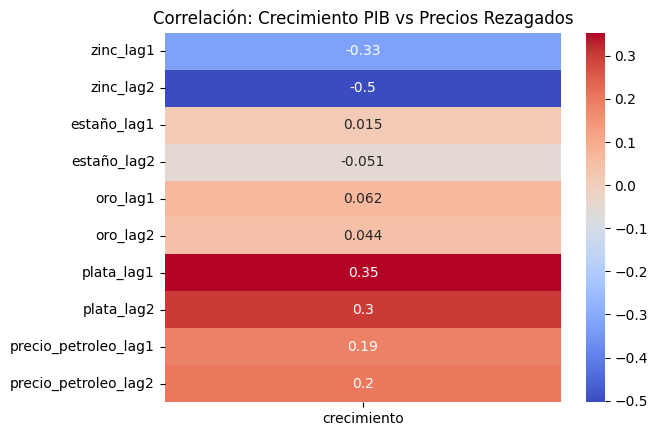

In [93]:
variables_rezagadas = ['zinc_lag1', 'zinc_lag2', 
                       'estaño_lag1', 'estaño_lag2', 
                       'oro_lag1', 'oro_lag2', 
                       'plata_lag1', 'plata_lag2', 
                       'precio_petroleo_lag1', 'precio_petroleo_lag2']

correlaciones_crecimiento = df[['crecimiento'] + variables_rezagadas].corr()
correlaciones_crecimiento = correlaciones_crecimiento[['crecimiento']].drop('crecimiento')

sns.heatmap(correlaciones_crecimiento, annot=True, cmap='coolwarm')
plt.title("Correlación: Crecimiento PIB vs Precios Rezagados")
plt.show()

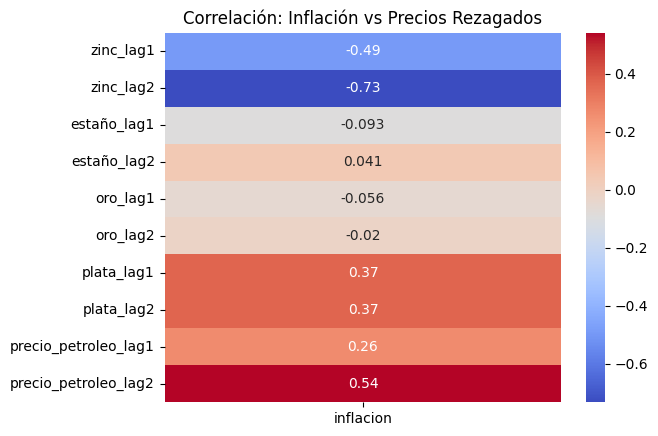

In [94]:
correlaciones_inflacion = df[['inflacion', *variables_rezagadas]].corr()
correlaciones_inflacion = correlaciones_inflacion[['inflacion']].drop('inflacion')

sns.heatmap(correlaciones_inflacion, annot=True, cmap='coolwarm')
plt.title("Correlación: Inflación vs Precios Rezagados")
plt.show()


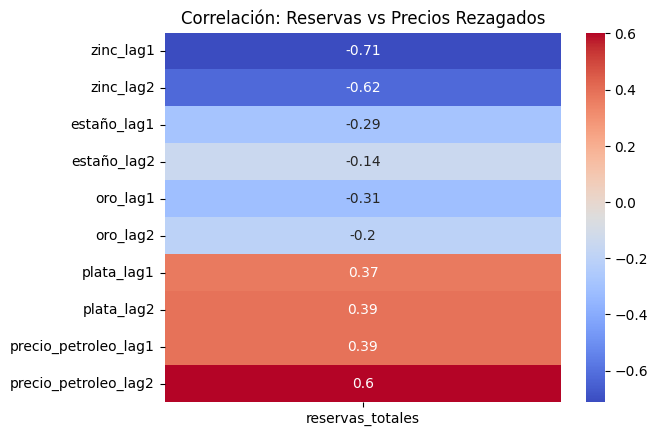

In [95]:
correlaciones_reservas = df[['reservas_totales', *variables_rezagadas]].corr()
correlaciones_reservas = correlaciones_reservas[['reservas_totales']].drop('reservas_totales')

sns.heatmap(correlaciones_reservas, annot=True, cmap='coolwarm')
plt.title("Correlación: Reservas vs Precios Rezagados")
plt.show()


In [98]:
from statsmodels.tsa.stattools import adfuller
df["precio_petroleo_diff"] = df["precio_petroleo"].pct_change() * 100
df = df.dropna()
def adf_test(series):
    result = adfuller(series.dropna())
    return {"ADF Statistic": result[0], "p-value": result[1]}
adf_test(df["crecimiento"])


{'ADF Statistic': -3.123910048089374, 'p-value': 0.024833598312198047}

In [97]:
from statsmodels.tsa.stattools import grangercausalitytests

grangercausalitytests(df[['crecimiento', 'precio_petroleo_diff']], maxlag=1)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0047  , p=0.9467  , df_denom=10, df_num=1
ssr based chi2 test:   chi2=0.0061  , p=0.9377  , df=1
likelihood ratio test: chi2=0.0061  , p=0.9377  , df=1
parameter F test:         F=0.0047  , p=0.9467  , df_denom=10, df_num=1


{1: ({'ssr_ftest': (0.0047045610717232015, 0.9466682614674624, 10.0, 1),
   'ssr_chi2test': (0.006115929393240162, 0.9376654558722065, 1),
   'lrtest': (0.00611449120611951, 0.9376727704937762, 1),
   'params_ftest': (0.004704561071724731, 0.9466682614674561, 10.0, 1.0)},
   array([[0., 1., 0.]])])}